<a href="https://colab.research.google.com/github/simonarahi/AI_HR/blob/master/candidate_screening.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading Libraries

In [6]:
import io
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import sklearn

from sklearn import metrics
from sklearn import datasets, linear_model
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.datasets import make_classification
import statsmodels.formula.api as smf

from time import time

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.svm import SVC 
from sklearn.svm import LinearSVR
from sklearn.linear_model import Lasso, Ridge
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from pylab import rcParams
import seaborn as sb

from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Loading Data Set

In [3]:
from google.colab import files
uploaded = files.upload()

Saving HR_dataset.csv to HR_dataset.csv


In [4]:
HR = pd.read_csv(io.BytesIO(uploaded['HR_dataset.csv']))

In [5]:
HR.head()

,Employee_Name,EmpID,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,PayRate,Termd,PositionID,Position,State,Zip,DOB,Sex,MaritalDesc,CitizenDesc,HispanicLatino,RaceDesc,DateofHire,DateofTermination,TermReason,EmploymentStatus,Department,ManagerName,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30
0,"Brown, Mia",1.103024e+09,1.0,1.0,0.0,1.0,1.0,3.0,1.0,28.50,0.0,1.0,Accountant I,MA,1450.0,11/24/87,F,Married,US Citizen,No,Black or African American,10/27/2008,NaN,N/A - still employed,Active,Admin Offices,Brandon R. LeBlanc,1.0,Diversity Job Fair,Fully Meets,2.04,2.0,6.0,1/15/2019,0.0
1,"LaRotonda, William",1.106027e+09,0.0,2.0,1.0,1.0,1.0,3.0,0.0,23.00,0.0,1.0,Accountant I,MA,1460.0,04/26/84,M,Divorced,US Citizen,No,Black or African American,1/6/2014,NaN,N/A - still employed,Active,Admin Offices,Brandon R. LeBlanc,1.0,Website Banner Ads,Fully Meets,5.00,4.0,4.0,1/17/2019,0.0
2,"Steans, Tyrone",1.302053e+09,0.0,0.0,1.0,1.0,1.0,3.0,0.0,29.00,0.0,1.0,Accountant I,MA,2703.0,09/01/86,M,Single,US Citizen,No,White,9/29/2014,NaN,N/A - still employed,Active,Admin Offices,Brandon R. LeBlanc,1.0,Internet Search,Fully Meets,3.90,5.0,5.0,1/18/2019,0.0
3,"Howard, Estelle",1.211051e+09,1.0,1.0,0.0,1.0,1.0,3.0,0.0,21.50,1.0,2.0,Administrative Assistant,MA,2170.0,09/16/85,F,Married,US Citizen,No,White,2/16/2015,04/15/15,NaN,Terminated for Cause,Admin Offices,Brandon R. LeBlanc,1.0,Pay Per Click - Google,Fully Meets,3.24,3.0,4.0,NaN,NaN
4,"Singh, Nan",1.307060e+09,0.0,0.0,0.0,1.0,1.0,3.0,0.0,16.56,0.0,2.0,Administrative Assistant,MA,2330.0,05/19/88,F,Single,US Citizen,No,White,5/1/2015,NaN,N/A - still employed,Active,Admin Offices,Brandon R. LeBlanc,1.0,Website Banner Ads,Fully Meets,5.00,3.0,5.0,1/15/2019,0.0


## Data Exploration

In [62]:
HR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401 entries, 0 to 400
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Employee_Name               310 non-null    object 
 1   EmpID                       310 non-null    float64
 2   MarriedID                   310 non-null    float64
 3   MaritalStatusID             310 non-null    float64
 4   GenderID                    310 non-null    float64
 5   EmpStatusID                 310 non-null    float64
 6   DeptID                      310 non-null    float64
 7   PerfScoreID                 310 non-null    float64
 8   FromDiversityJobFairID      310 non-null    float64
 9   PayRate                     310 non-null    float64
 10  Termd                       310 non-null    float64
 11  PositionID                  310 non-null    float64
 12  Position                    310 non-null    object 
 13  State                       310 non

In [9]:
# looking at columns we have
HR.columns

Index(['Employee_Name', 'EmpID', 'MarriedID', 'MaritalStatusID', 'GenderID',
       'EmpStatusID', 'DeptID', 'PerfScoreID', 'FromDiversityJobFairID',
       'PayRate', 'Termd', 'PositionID', 'Position', 'State', 'Zip', 'DOB',
       'Sex', 'MaritalDesc', 'CitizenDesc', 'HispanicLatino', 'RaceDesc',
       'DateofHire', 'DateofTermination', 'TermReason', 'EmploymentStatus',
       'Department', 'ManagerName', 'ManagerID', 'RecruitmentSource',
       'PerformanceScore', 'EngagementSurvey', 'EmpSatisfaction',
       'SpecialProjectsCount', 'LastPerformanceReview_Date', 'DaysLateLast30'],
      dtype='object')

Text(0, 0.5, 'Avg Pay Rate')

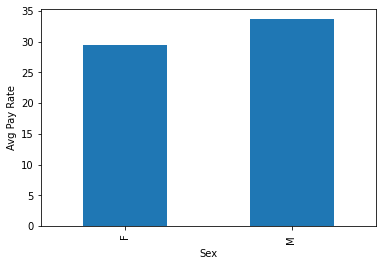

In [10]:
# looking at average payrates for each sex
plot1 = HR.groupby(['Sex']).mean().PayRate.plot(kind='bar')
plot1.set_ylabel("Avg Pay Rate")

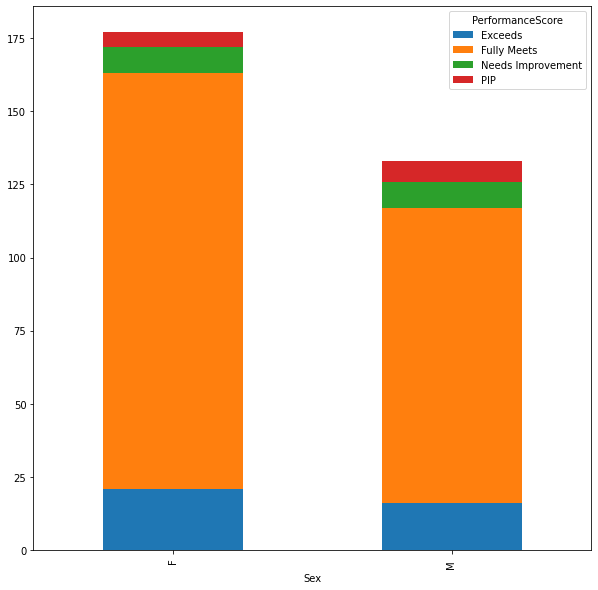

In [11]:
# looking at performance scores: M vs F
HR.groupby(['Sex', 'PerformanceScore']).size().unstack().plot(kind='bar', stacked=True, figsize=(10,10))


Text(0.5, 1.0, 'Missing values in the dataset')

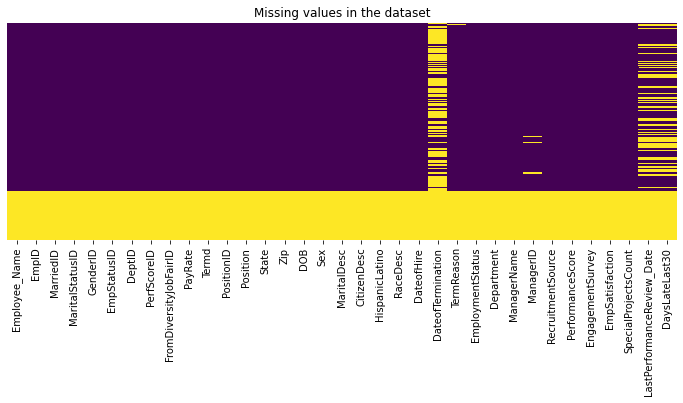

In [12]:
# plotting missing values
plt.figure(figsize=(12,4))
sns.heatmap(HR.isnull(),cbar=False,cmap='viridis',yticklabels=False)
plt.title('Missing values in the dataset')

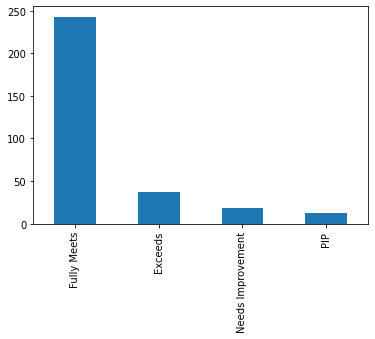

In [13]:
# counts of instances per class for Performance Score 
HR['PerformanceScore'].value_counts().plot(kind='bar')

In [14]:
# pairwise relationships with quantitative variables
HRquant = HR.filter(['PayRate','EngagementSurvey','EmpSatisfaction', 'SpecialProjectCounts'], axis=1)
HRquant.corr()

,PayRate,EngagementSurvey,EmpSatisfaction
PayRate,1.000000,-0.024223,0.061525
EngagementSurvey,-0.024223,1.000000,-0.017123
EmpSatisfaction,0.061525,-0.017123,1.000000


In [16]:
# calculating Shannon's entropy to ensure balance across classes
from scipy.stats import entropy
pd_series = pd.Series(HR['PerformanceScore'])
counts = pd_series.value_counts()
entropy = entropy(counts)
balance = entropy/np.log(4)

print(entropy)
print(balance)

0.7357224105786224
0.5307115366063262


## Data Preparation

In [63]:
# dropping irrelevant columns for model
HR.drop(columns=['FromDiversityJobFairID', 'Employee_Name', 'EmpID', 'MarriedID', 'MaritalStatusID', 'GenderID',
       'EmpStatusID', 'DeptID', 'PerfScoreID', 'Termd', 'PositionID', 'State', 'Zip',
       'HispanicLatino','DateofHire', 'DateofTermination', 'TermReason',
       'ManagerName', 'ManagerID', 'LastPerformanceReview_Date', 'DaysLateLast30'], inplace=True)

In [26]:
HR.sample(10)

,PayRate,Position,DOB,Sex,MaritalDesc,CitizenDesc,RaceDesc,EmploymentStatus,Department,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount
323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131,22.0,Production Technician I,05/16/83,F,Single,US Citizen,White,Active,Production,Professional Society,Needs Improvement,2.44,5.0,0.0
377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,19.0,Production Technician I,07/07/84,F,Single,US Citizen,White,Active,Production,Vendor Referral,Fully Meets,2.79,5.0,0.0
370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,18.5,Production Technician I,09/30/80,F,Single,US Citizen,Two or more races,Terminated for Cause,Production,Professional Society,PIP,3.09,2.0,0.0
102,21.0,Production Technician I,09/09/65,M,Married,Eligible NonCitizen,White,Voluntarily Terminated,Production,Website Banner Ads,Fully Meets,5.00,3.0,0.0
264,27.0,Production Technician II,12/08/83,F,Separated,US Citizen,American Indian or Alaska Native,Leave of Absence,Production,Word of Mouth,Fully Meets,2.57,5.0,0.0
126,20.0,Production Technician I,11/22/77,F,Married,US Citizen,White,Active,Production,Other,Fully Meets,5.00,4.0,0.0


In [64]:
HR.columns
HR.shape

(401, 14)

In [65]:
# dropping NA
HR.dropna(inplace=True)

In [66]:
HRcorr = pd.get_dummies(HR)
HRcorr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310 entries, 0 to 309
Columns: 396 entries, PayRate to PerformanceScore_PIP
dtypes: float64(4), uint8(392)
memory usage: 130.8 KB


In [67]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 100)

In [68]:
HRcorr.corr()

,PayRate,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,Position_Accountant I,Position_Administrative Assistant,Position_Area Sales Manager,Position_BI Developer,Position_BI Director,Position_CIO,Position_Data Analyst,Position_Data Analyst,Position_Data Architect,Position_Database Administrator,Position_Director of Operations,Position_Director of Sales,Position_Enterprise Architect,Position_IT Director,Position_IT Manager - DB,Position_IT Manager - Infra,Position_IT Manager - Support,Position_IT Support,Position_Network Engineer,Position_President & CEO,Position_Principal Data Architect,...,RecruitmentSource_Company Intranet - Partner,RecruitmentSource_Diversity Job Fair,RecruitmentSource_Employee Referral,RecruitmentSource_Glassdoor,RecruitmentSource_Indeed,RecruitmentSource_Information Session,RecruitmentSource_Internet Search,RecruitmentSource_MBTA ads,RecruitmentSource_Monster.com,RecruitmentSource_Newspager/Magazine,RecruitmentSource_On-campus Recruiting,RecruitmentSource_On-line Web application,RecruitmentSource_Other,RecruitmentSource_Pay Per Click,RecruitmentSource_Pay Per Click - Google,RecruitmentSource_Professional Society,RecruitmentSource_Search Engine - Google Bing Yahoo,RecruitmentSource_Social Networks - Facebook Twitter etc,RecruitmentSource_Vendor Referral,RecruitmentSource_Website Banner Ads,RecruitmentSource_Word of Mouth,PerformanceScore_Exceeds,PerformanceScore_Fully Meets,PerformanceScore_Needs Improvement,PerformanceScore_PIP
PayRate,1.000000,-0.024223,0.061525,0.448484,-0.028651,-0.075722,0.481403,0.103958,0.119323,0.124879,0.061649,0.050800,0.087840,0.081990,0.106359,0.106359,0.099692,0.124879,0.053596,0.117471,0.121175,0.035237,0.062816,0.180438,0.100803,...,0.113767,-0.053474,0.107760,-0.046533,0.184417,-0.027263,0.034364,-0.106177,0.005725,-0.119783,-0.101930,-0.049206,0.075541,-0.060318,0.153755,-0.001236,-0.121611,-0.053499,0.139063,0.139213,-0.142194,0.018989,0.002159,-0.035588,0.006622
EngagementSurvey,-0.024223,1.000000,-0.017123,-0.040253,0.024134,0.052264,0.006866,-0.098014,0.051563,-0.097665,0.022502,-0.050424,0.070989,-0.007164,-0.013779,-0.093250,-0.017311,0.018892,-0.037342,-0.041594,-0.059254,-0.018738,0.032981,0.066133,0.024190,...,0.071872,-0.113663,0.025911,-0.031941,-0.036265,0.022663,0.005041,-0.068240,0.036156,0.123774,-0.041987,0.073638,-0.016684,-0.011130,0.001753,-0.103148,0.076015,0.018769,-0.055435,0.098206,-0.046429,-0.074036,0.166964,-0.141603,-0.060156
EmpSatisfaction,0.061525,-0.017123,1.000000,0.036456,-0.024317,-0.060558,0.037260,0.045229,0.069430,0.069430,-0.005547,-0.055706,-0.055706,-0.012719,0.069430,0.006862,0.069430,0.069430,0.054034,-0.055706,0.069430,0.019633,-0.097212,-0.055706,-0.055706,...,-0.055706,-0.034350,0.016557,0.060405,0.019633,0.013792,0.016947,-0.017695,-0.084533,0.045120,0.024206,0.069430,-0.042535,0.006862,-0.023955,-0.026088,0.009667,0.138204,0.010667,-0.116365,0.007537,0.088182,0.134912,-0.076245,-0.343636
SpecialProjectsCount,0.448484,-0.040253,0.036456,1.000000,0.159562,0.131497,-0.159119,0.233237,0.140277,0.116051,0.300820,0.091825,0.091825,0.228478,-0.029306,-0.029306,0.140277,0.091825,0.181545,0.116051,0.091825,0.306032,0.261194,-0.029306,0.140277,...,0.116051,0.032642,0.190032,0.066580,0.340688,0.087169,-0.022516,-0.093916,-0.066987,-0.127902,-0.067768,-0.029306,-0.072714,-0.029306,-0.018604,-0.001082,-0.081942,-0.098808,0.229538,-0.046095,-0.107777,-0.015924,0.080262,-0.069162,-0.060647
Position_Accountant I,-0.028651,0.024134,-0.024317,0.159562,1.000000,-0.009772,-0.030534,-0.011302,-0.005624,-0.005624,-0.015025,-0.005624,-0.005624,-0.012657,-0.005624,-0.005624,-0.005624,-0.005624,-0.007966,-0.005624,-0.005624,-0.016089,-0.012657,-0.005624,-0.005624,...,-0.005624,0.081400,-0.032951,-0.021499,-0.016089,-0.011302,0.225289,-0.023811,-0.028636,-0.024543,-0.019837,-0.005624,-0.017093,-0.005624,-0.026647,-0.025960,-0.029278,-0.018961,-0.022291,0.143711,-0.020682,-0.036392,0.051907,-0.024543,-0.019837
...,...,...,...,...,...,...,...,...,

In [69]:
from sklearn import tree
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [70]:
HRcorr.columns

Index(['PayRate', 'EngagementSurvey', 'EmpSatisfaction', 'SpecialProjectsCount',
       'Position_Accountant I', 'Position_Administrative Assistant', 'Position_Area Sales Manager',
       'Position_BI Developer', 'Position_BI Director', 'Position_CIO',
       ...
       'RecruitmentSource_Professional Society',
       'RecruitmentSource_Search Engine - Google Bing Yahoo',
       'RecruitmentSource_Social Networks - Facebook Twitter etc',
       'RecruitmentSource_Vendor Referral', 'RecruitmentSource_Website Banner Ads',
       'RecruitmentSource_Word of Mouth', 'PerformanceScore_Exceeds',
       'PerformanceScore_Fully Meets', 'PerformanceScore_Needs Improvement',
       'PerformanceScore_PIP'],
      dtype='object', length=396)

In [71]:
y = HR['PayRate']
X = HRcorr.drop(['PayRate'], axis=1)

In [72]:
HRcorr.sample(50)

,PayRate,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,Position_Accountant I,Position_Administrative Assistant,Position_Area Sales Manager,Position_BI Developer,Position_BI Director,Position_CIO,Position_Data Analyst,Position_Data Analyst,Position_Data Architect,Position_Database Administrator,Position_Director of Operations,Position_Director of Sales,Position_Enterprise Architect,Position_IT Director,Position_IT Manager - DB,Position_IT Manager - Infra,Position_IT Manager - Support,Position_IT Support,Position_Network Engineer,Position_President & CEO,Position_Principal Data Architect,...,RecruitmentSource_Company Intranet - Partner,RecruitmentSource_Diversity Job Fair,RecruitmentSource_Employee Referral,RecruitmentSource_Glassdoor,RecruitmentSource_Indeed,RecruitmentSource_Information Session,RecruitmentSource_Internet Search,RecruitmentSource_MBTA ads,RecruitmentSource_Monster.com,RecruitmentSource_Newspager/Magazine,RecruitmentSource_On-campus Recruiting,RecruitmentSource_On-line Web application,RecruitmentSource_Other,RecruitmentSource_Pay Per Click,RecruitmentSource_Pay Per Click - Google,RecruitmentSource_Professional Society,RecruitmentSource_Search Engine - Google Bing Yahoo,RecruitmentSource_Social Networks - Facebook Twitter etc,RecruitmentSource_Vendor Referral,RecruitmentSource_Website Banner Ads,RecruitmentSource_Word of Mouth,PerformanceScore_Exceeds,PerformanceScore_Fully Meets,PerformanceScore_Needs Improvement,PerformanceScore_PIP
98,22.00,3.45,4.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
176,20.00,2.81,5.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
13,55.00,4.50,5.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
25,55.00,2.19,5.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
118,17.00,1.79,4.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
104,16.00,5.00,3.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
107,24.00,5.00,5.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
223,23.00,5.00,5.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
245,26.10,1.64,4.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
39,55.00,4.94,3.0,5.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [74]:
X, y = make_classification(n_samples=1000, n_features=4,
                           n_informative=2, n_redundant=0,
                            random_state=0, shuffle=False)

### Classification Model: Random Forest

In [75]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)

In [76]:
HR['PayRate'].unique()

array([28.5 , 23.  , 29.  , 21.5 , 16.56, 20.5 , 55.  , 56.  , 55.5 ,
       54.  , 57.  , 45.  , 46.  , 63.5 , 65.  , 43.  , 48.5 , 40.1 ,
       34.  , 40.  , 35.5 , 41.  , 42.75, 39.55, 42.2 , 30.2 , 31.4 ,
       60.  , 62.  , 21.  , 63.  , 64.  , 28.99, 26.  , 27.49, 42.  ,
       37.  , 39.  , 27.  , 47.  , 28.  , 49.1 , 80.  , 54.5 , 50.5 ,
       51.  , 53.  , 38.5 , 52.  , 33.5 , 16.  , 20.  , 18.  , 24.  ,
       15.  , 22.  , 24.75, 17.  , 16.75, 19.  , 19.5 , 14.  , 16.76,
       15.75, 21.25, 24.5 , 18.5 , 19.75, 15.25, 23.5 , 15.2 , 25.  ,
       24.25, 26.1 , 26.39, 28.75, 22.5 , 60.25, 50.25, 52.25, 47.6 ,
       57.12, 55.51, 49.25, 48.  , 45.42, 34.95, 61.3 , 58.2 , 58.5 ,
       54.1 , 56.2 , 53.8 , 55.2 ])

In [87]:
feature_cols = HRcorr.columns
X = HRcorr[feature_cols]
y = HRcorr['PerformanceScore_Exceeds']
X_train, X_test, y_train, y_test=train_test_split(X, y, 
                                                  test_size = 0.25,
                                                  random_state = 123)

In [77]:
clf = RandomForestClassifier(n_estimators=500,criterion = 'entropy', max_depth=5,random_state=123)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [78]:
y_pred = clf.predict(X_test)

In [79]:
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))

Accuracy: 0.8846153846153846


Text(91.68, 0.5, 'predicted values')

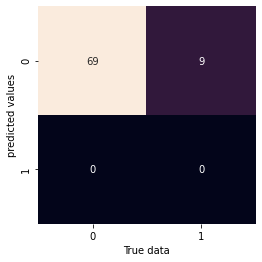

In [80]:
y_true = y_test.tolist()
mat = confusion_matrix(y_true,y_pred)
sns.heatmap(mat.T, square =True, annot = True, fmt = 'd', cbar= False)
plt.xlabel('True data')
plt.ylabel('predicted values')

In [ ]:
#feature_importances = pd.Series(clf.feature_importances_, index = X.columns)
#feature_importances = feature_importances.sort_values()
#feature_importances.plot(kind='barh', figsize = (12,25))

# Classification Model 2: SVM

## Data Preparation

In [88]:
features = HRcorr.loc[:, HRcorr.columns != 'PerformanceScore_Exceeds']
labels = HRcorr[['PerformanceScore_Exceeds']]

In [89]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [1]:
y_pred = svclassifier.predict(X_test)
svm_accuracy = svm_model_linear.score(X_test, y_test)

NameError: ignored

In [91]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Accuracy:", svm_accuracy)

[[69  0]
 [ 0  9]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        69
           1       1.00      1.00      1.00         9

    accuracy                           1.00        78
   macro avg       1.00      1.00      1.00        78
weighted avg       1.00      1.00      1.00        78



## Classification Model 3: kNN

In [92]:
print(X_train.shape)
print(y_test.shape)

(232, 396)
(78,)


In [95]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

k_range = range(1,21)
scores = {}
scores_list = []
for k in k_range:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  y_pred=knn.predict(X_test)
  scores[k] = metrics.accuracy_score(y_test, y_pred)
  scores_list.append(metrics.accuracy_score(y_test, y_pred))

Text(0, 0.5, 'Testing Accuracy')

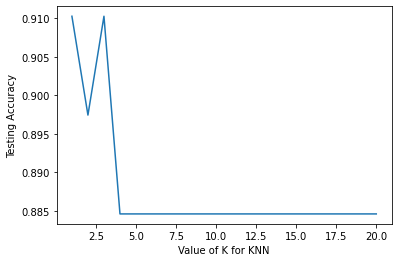

In [96]:
plt.plot(k_range, scores_list)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

For K=3, the model accuracy reaches 91%.

In [97]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [100]:
#y_predict = knn.predict(X_test)

# Method 2: Multiclass

In this second method, I will choose different features to predict the performance score of employees. This will be a multiclass classification problem.

In [8]:
HR = pd.read_csv(io.BytesIO(uploaded['HR_dataset.csv']))

### Preprocessing

In [9]:
HR.drop(columns=['GenderID', 'Employee_Name', 'EmpID', 'MarriedID', 'MaritalStatusID', 'EmpStatusID' ,
                 'DeptID', 'PositionID', 'DOB','State', 'Zip', 'CitizenDesc', 
                 'HispanicLatino', 'DateofHire', 'DateofTermination', 'TermReason', 
                 'ManagerName', 'ManagerID', 'LastPerformanceReview_Date', 'DaysLateLast30', 'PerformanceScore'], inplace=True)

In [10]:
HR.info()
HR.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401 entries, 0 to 400
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PerfScoreID             310 non-null    float64
 1   FromDiversityJobFairID  310 non-null    float64
 2   PayRate                 310 non-null    float64
 3   Termd                   310 non-null    float64
 4   Position                310 non-null    object 
 5   Sex                     310 non-null    object 
 6   MaritalDesc             310 non-null    object 
 7   RaceDesc                310 non-null    object 
 8   EmploymentStatus        310 non-null    object 
 9   Department              310 non-null    object 
 10  RecruitmentSource       310 non-null    object 
 11  EngagementSurvey        310 non-null    float64
 12  EmpSatisfaction         310 non-null    float64
 13  SpecialProjectsCount    310 non-null    float64
dtypes: float64(7), object(7)
memory usage: 44.

In [11]:
# encoding our categorical nominal variables 
HR1 = pd.get_dummies(HR, columns=['Sex', 'Position', 'MaritalDesc', 'RaceDesc',
                                 'EmploymentStatus', 'Department', 'RecruitmentSource'])
HR1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310 entries, 0 to 309
Data columns (total 86 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   PerfScoreID                                               310 non-null    float64
 1   FromDiversityJobFairID                                    310 non-null    float64
 2   PayRate                                                   310 non-null    float64
 3   Termd                                                     310 non-null    float64
 4   EngagementSurvey                                          310 non-null    float64
 5   EmpSatisfaction                                           310 non-null    float64
 6   SpecialProjectsCount                                      310 non-null    float64
 7   Sex_F                                                     310 non-null    uint8  
 8   Sex_M               

In [12]:
# selecting features columns (x) and response (y)
X = HR1.iloc[:,1:].values
y = HR1.iloc[:, 0].values
print(X.shape)
print(y.shape)

(310, 85)
(310,)


In [13]:
# splitting data into test (25%) and train (75%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [14]:
# handling imbalanced classes by oversampling minority class
smote = SMOTE('minority')

X_sm, y_sm = smote.fit_sample(X_train, y_train)
print(X_sm.shape, y_sm.shape)

(404, 85) (404,)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Random Forest

In [17]:
rf = RandomForestClassifier(n_estimators=10, criterion="entropy", random_state=0)
rf.fit(X_sm, y_sm)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [24]:
# predictions
rf_pred = rf.predict(X_test)

Accuracy score: 0.7948717948717948
Precision score: 0.7948717948717948
Recall score: 0.7948717948717948


Text(91.68, 0.5, 'Predicted Values')

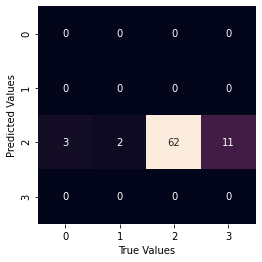

In [21]:
rf_accuracy = metrics.accuracy_score(y_test, rf_pred) 
print("Accuracy score:",rf_accuracy)
precision = metrics.precision_score(y_test, rf_pred, average='micro') 
print("Precision score:",precision)
recall = metrics.recall_score(y_test, rf_pred, average='micro') 
print("Recall score:",recall)

mat = confusion_matrix(y_test,rf_pred)
sns.heatmap(mat.T, square =True, annot = True, fmt = 'd', cbar= False)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

## Naive Bayes

In [25]:
gnb = GaussianNB().fit(X_sm, y_sm)

In [26]:
gnb_predictions = gnb.predict(X_test)

Accuracy Score: 0.28205128205128205


Text(91.68, 0.5, 'Predicted Values')

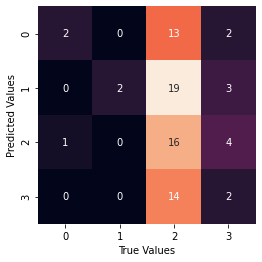

In [27]:
print('Accuracy Score:', accuracy_score(y_test, gnb_predictions))
mat = confusion_matrix(y_test,gnb_predictions)
sns.heatmap(mat.T, square =True, annot = True, fmt = 'd', cbar= False)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

## SVM

In [28]:
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_sm, y_sm) 
svm_predictions = svm_model_linear.predict(X_test) 
  
# model accuracy  
svm_accuracy = svm_model_linear.score(X_test, y_test) 
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, svm_predictions)

Accuracy Score: 0.8076923076923077


Text(91.68, 0.5, 'Predicted Values')

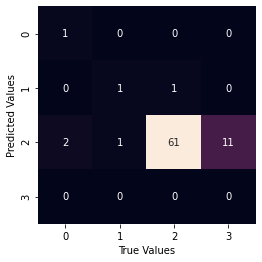

In [29]:
print('Accuracy Score:', svm_accuracy)
mat = confusion_matrix(y_test,svm_predictions)
sns.heatmap(mat.T, square =True, annot = True, fmt = 'd', cbar= False)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

## kNN

Text(0, 0.5, 'Testing Accuracy')

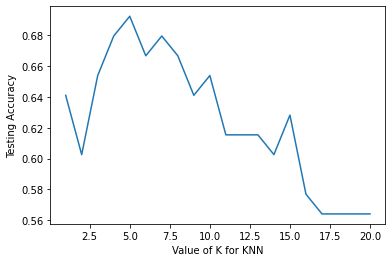

In [39]:
# to check which k gives the highest accuracy
k_range = range(1,21)
scores = {}
scores_list = []
for k in k_range:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_sm, y_sm)
  knn_pred=knn.predict(X_test)
  scores[k] = metrics.accuracy_score(y_test, knn_pred)
  scores_list.append(metrics.accuracy_score(y_test, knn_pred))


plt.plot(k_range, scores_list)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

In [40]:
 knn = KNeighborsClassifier(n_neighbors = 5).fit(X_sm, y_sm)

Accuracy Score: 0.6923076923076923


Text(91.68, 0.5, 'Predicted Values')

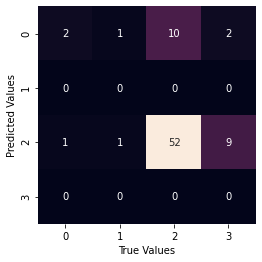

In [41]:
knn_accuracy = knn.score(X_test, y_test)
knn_predictions = knn.predict(X_test)  
print('Accuracy Score:', knn_accuracy)
mat = confusion_matrix(y_test,knn_predictions)
sns.heatmap(mat.T, square =True, annot = True, fmt = 'd', cbar= False)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')